# Comparison with clinical plans

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
colors = sns.color_palette()

sys.path.append('../src')
import raybay

In [2]:
folders = ['SBRT_lung_minsun', 'ZZ_MK_LLungSBRT3778', 'ZZ_MK_RLungSBRT4076',
           'ZZ_MK_RULungSBRT3796', 'ZZ_MK_RLSBRT1931']

In [3]:
def plotConvergenceA(folder, labels=True, legend=True):
    # Load data
    approved = np.load(folder + '/approved/res_approved.pkl', allow_pickle=True)
    default = np.load(folder + '/default/res_default.pkl', allow_pickle=True)
    dummy = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    
    # Plot convergence
    plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, approved.goal_dict)[0],
                       raybay.get_utility(bayes.goal_df, approved.goal_dict)[0]], ':', color=colors[1])
    plt.plot([0, 100], [raybay.get_utility(bayes.goal_df, default.goal_dict)[0],
                       raybay.get_utility(bayes.goal_df, default.goal_dict)[0]], ':', color=colors[0])
    plt.plot(np.arange(1, 101), -np.minimum.accumulate(dummy.opt_result.func_vals), color=colors[4])
    plt.plot(np.arange(1, 101), -np.minimum.accumulate(bayes.opt_result.func_vals), color=colors[2])
    
    # Add labels
    if labels:
        plt.xlabel('Iteration ($t$)')
        plt.ylabel('Linear-Quadratic Utility ($g$)')
        if legend:
            plt.legend(['Clinical', 'Default', 'Random', 'Bayes'], loc='lower right')
    else:
        ylim = plt.ylim()
        plt.xticks(ticks=np.arange(0, 101, 20), labels=[])
        plt.yticks(ticks=plt.yticks()[0], labels=[])
        plt.ylim(ylim)
        if legend:
            plt.legend(['', '', '', ''], frameon=False, loc='lower right')

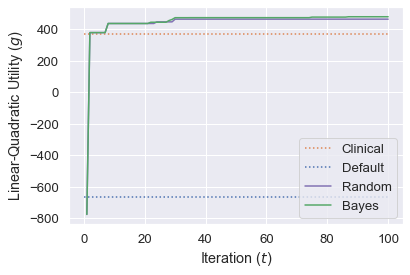

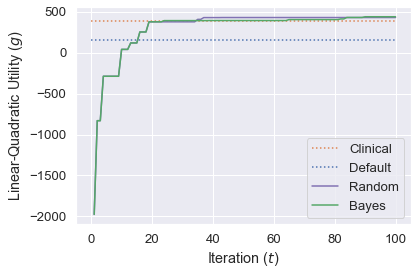

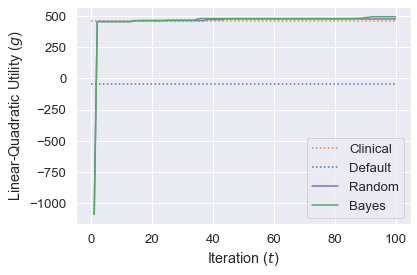

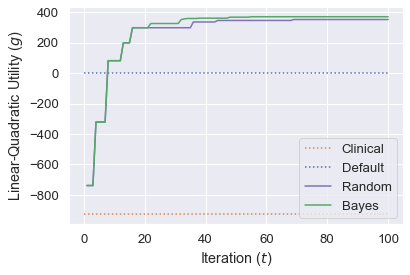

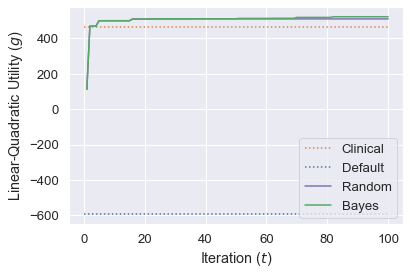

In [4]:
# Plot convergence (zoomed out)
for ii in range(len(folders)):
    plt.figure()
    plotConvergenceA(folders[ii])
    plt.savefig(f'fig5{chr(2*ii + 97)}.png', dpi=300, bbox_inches='tight')

In [5]:
def plotConvergenceB(folder, labels=True, legend=True, clinical=False):
    # Load data
    approved = np.load(folder + '/approved/res_approved.pkl', allow_pickle=True)
    dummy = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    default = np.load(folder + '/default/res_default.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    
    # Plot convergence
    h1, = plt.plot(np.arange(20, 101), -np.minimum.accumulate(dummy.opt_result.func_vals)[19:], color=colors[4])
    h2, = plt.plot(np.arange(20, 101), -np.minimum.accumulate(bayes.opt_result.func_vals)[19:], color=colors[2])
    ylim = plt.ylim()
    if clinical:
        h3, = plt.plot([20, 100], [raybay.get_utility(bayes.goal_df, approved.goal_dict)[0],
                 raybay.get_utility(bayes.goal_df, approved.goal_dict)[0]], ':', color=colors[1])
        h4, = plt.plot([20, 100], [raybay.get_utility(bayes.goal_df, default.goal_dict)[0],
                       raybay.get_utility(bayes.goal_df, default.goal_dict)[0]], ':', color=colors[0])
    
    plt.ylim(ylim)
    # Add labels
    if labels:
        plt.xlabel('Iteration ($t$)')
        plt.ylabel('Linear-Quadratic Utility ($g$)')
        if legend:
            if clinical:
                plt.legend(['Clinical', 'Random', 'Bayes'], loc='lower right')
            else:
                plt.legend(['Random', 'Bayes'], loc='lower right')
    else:
        #ylim = plt.ylim()
        plt.xticks(ticks=np.arange(20, 101, 20), labels=[])
        plt.yticks(ticks=plt.yticks()[0], labels=[])
        plt.ylim(ylim)
        if legend:
            if clinical:
                plt.legend([h3, h4, h1, h2], ['', '', '', ''], loc='lower right', frameon=False)
            else:
                plt.legend(['', ''], loc='lower right', frameon=False)

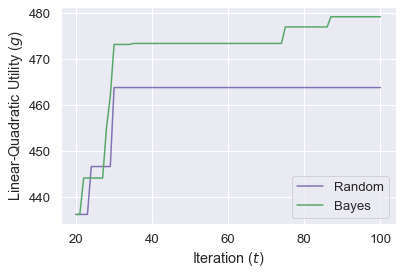

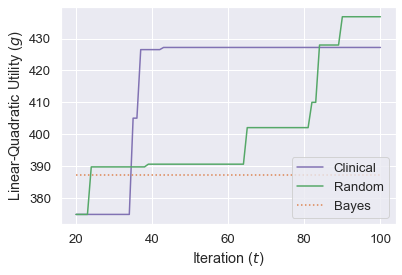

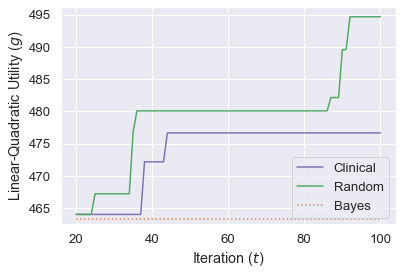

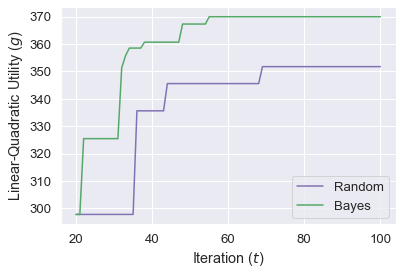

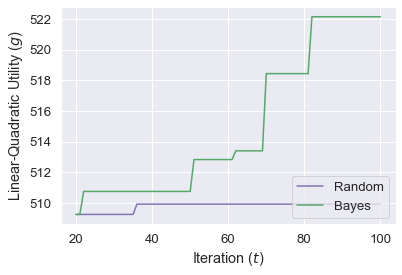

In [6]:
# Plot convergence (zoomed in)
for ii in range(len(folders)):
    clinical = True if ii in [1, 2] else False
    plt.figure()
    plotConvergenceB(folders[ii], clinical=clinical)
    plt.savefig(f'fig5{chr(98+2*ii)}.png', dpi=300, bbox_inches='tight')

In [7]:
# Load data
res_list = []
for folder in folders:
    approved = np.load(folder + '/approved/res_approved.pkl', allow_pickle=True)
    dummy = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    temp = [approved, dummy, bayes]
    res_list.append(temp)
roi_names = ['Chestwall', 'D2cm', 'Esophagus', 'Lungs', 'Lungs', 'PTV', 'PTV', 'Ribs', 'Ribs',
             'Spinal Cord', 'Spinal Cord']

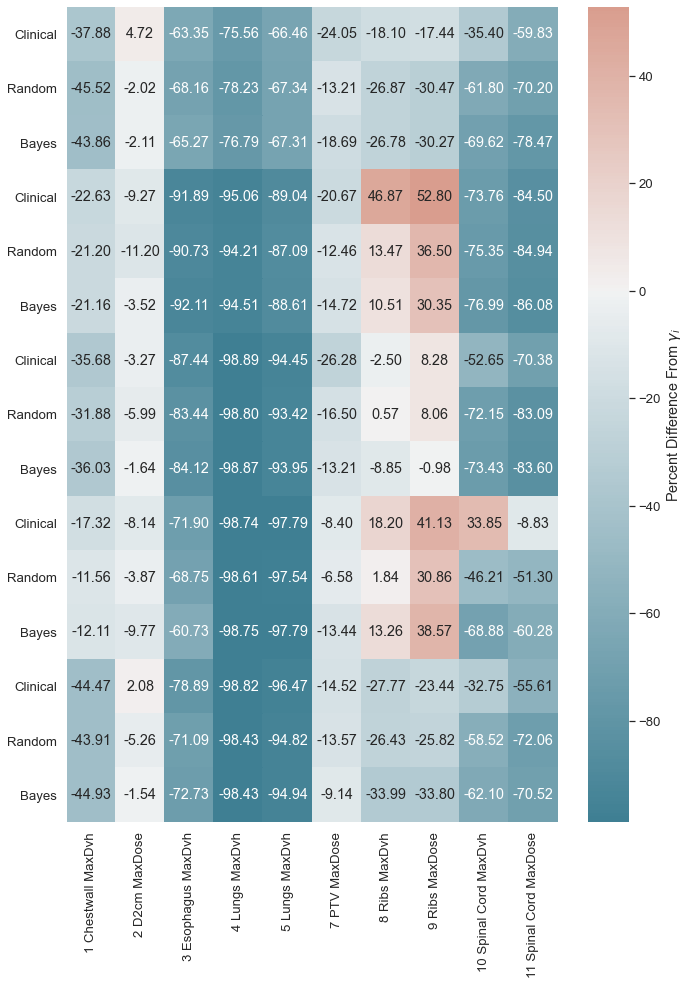

In [8]:
# Plot goal values (relative to gamma)

# Calculate goal values
val_list = []
roi_dict = {}
for index, row in res_list[0][2].goal_df.iterrows():
    goal_vals = []
    if index != 5:
        roi_dict[f"{index + 1} {roi_names[index]} {row['Type']}"] = index + 1
        for case in res_list:
            # Get indices of optimal values
            idx_max = [0]
            idx_max.append(np.argmin(case[1].opt_result.func_vals))
            idx_max.append(np.argmin(case[2].opt_result.func_vals))
            
            # Get goal values
            for ii in range(len(case)):
                level = case[2].goal_df.iloc[index]['AcceptanceLevel']
                val = case[ii].goal_dict[index][idx_max[ii]]
                goal_vals.append(100*(val - level)/level)
        val_list.append(goal_vals)
            
# Plot results
columns = [f'{name}' for ii in range(1,6) for name in ['Clinical', 'Random', 'Bayes']]
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
fig, ax = plt.subplots(1, figsize=(len(bayes.goal_df), len(columns)))
sns.heatmap(val_df.transpose(), cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Percent Difference From $\gamma_i$'}, ax=ax)
plt.yticks(rotation='horizontal')
plt.savefig('fig6.png', dpi=300, bbox_inches='tight')

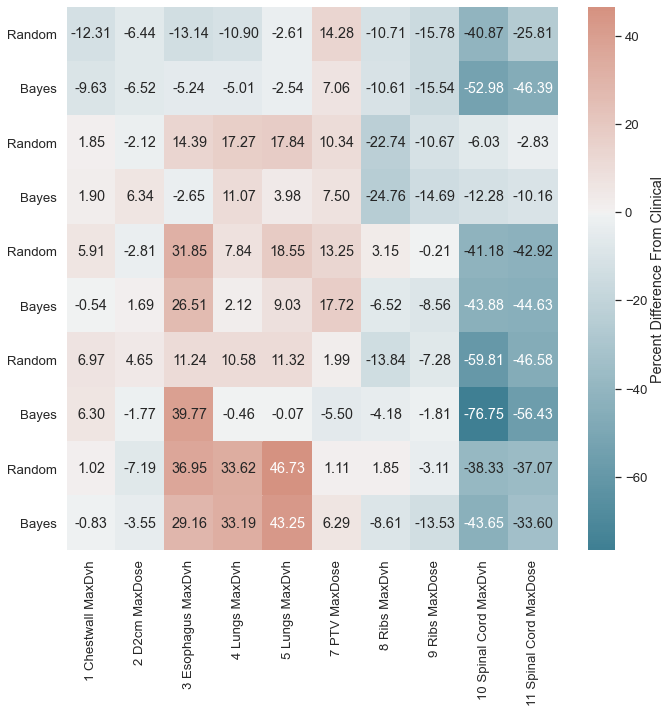

In [9]:
# Plot goal values (relative to clinical)

# Calculate goal values
val_list = []
roi_dict = {}
for index, row in res_list[0][2].goal_df.iterrows():
    goal_vals = []
    if index != 5:
        roi_dict[f"{index + 1} {roi_names[index]} {row['Type']}"] = index + 1
        for case in res_list:
            # Get indices of optimal values
            idx_max = [np.argmin(case[1].opt_result.func_vals), np.argmin(case[2].opt_result.func_vals)]
            
            # Get goal values
            for ii in [1, 2]:
                level = case[0].goal_dict[index][0]
                val = case[ii].goal_dict[index][idx_max[ii - 1]]
                goal_vals.append(100*(val - level)/level)
        val_list.append(goal_vals)
            
# Plot results
columns = [f'{name}' for ii in range(1,6) for name in ['Random', 'Bayes']]
val_df = pd.DataFrame(columns=columns, data=val_list, index=roi_dict)
fig, ax = plt.subplots(1, figsize=(len(bayes.goal_df), len(columns)))
sns.heatmap(val_df.transpose(), cmap=sns.diverging_palette(220, 20, n=256), center=0,
            annot=True, fmt=".2f", cbar_kws={'label': 'Percent Difference From Clinical'}, ax=ax)
plt.yticks(rotation='horizontal')
plt.savefig('fig7.png', dpi=300, bbox_inches='tight')

In [10]:
def plotDvh(folder, legend=True, labels=True):
    # Load data
    approved = np.load(folder + '/approved/res_approved.pkl', allow_pickle=True)
    dummy = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    
    # Normalize data if flag == 1
    idx_max = np.argmin(bayes.opt_result.func_vals)
    if bayes.flag_list[idx_max] == 1:
        coeff = bayes.goal_dict[6][idx_max]/bayes.dvh_dict['Dose'][-1]
    else:
        coeff = 1.0
        
    # Plot DVH
    names = list(approved.roi_list)
    names.sort()
    roi_names = ['Chestwall', 'D2cm', 'Esophagus', 'Lungs', 'PTV', 'Ribs', 'Spinal Cord']
    handles = []
    for ii, roi in enumerate(names):
        color = colors[ii]
        plt.plot(approved.dvh_dict['Dose']/100, 100*approved.dvh_dict[roi],':',color=color)
        plt.plot(dummy.dvh_dict['Dose']/100, 100*dummy.dvh_dict[roi],'--', color=color)
        p, = plt.plot(coeff*bayes.dvh_dict['Dose']/100, 100*bayes.dvh_dict[roi],color=color)
        handles.append(p)
        
    # Add labels
    if labels:
        plt.xlabel('Dose (Gy)')
        plt.ylabel('Volume (%)')
        if legend:
            plt.legend(handles, roi_names, bbox_to_anchor=(1, 1))
    else:
        xlim = plt.xlim()
        plt.xticks(ticks=plt.xticks()[0], labels=[])
        plt.yticks(ticks=np.arange(0, 101, 20), labels=[])
        plt.xlim(xlim)
        if legend:
            plt.legend(handles, ['']*len(roi_names), bbox_to_anchor=(1.2, 1), frameon=False)

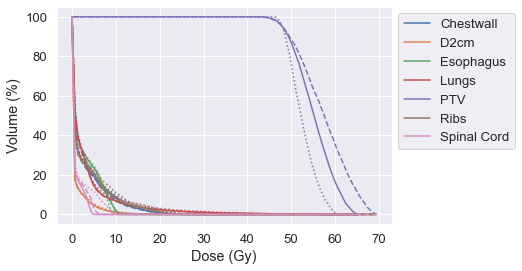

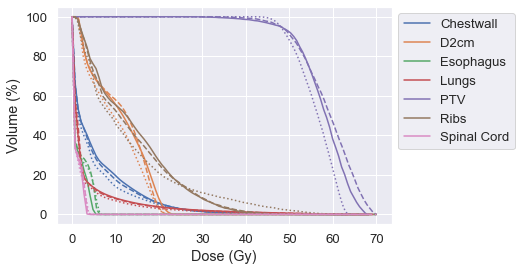

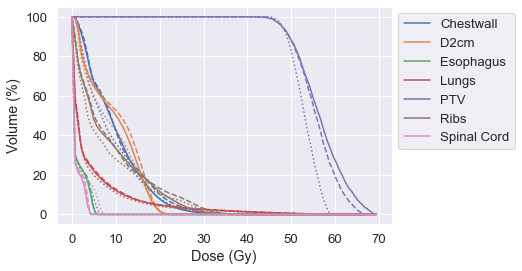

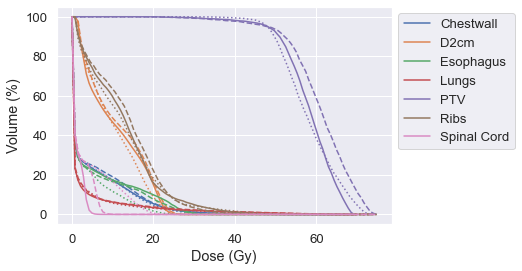

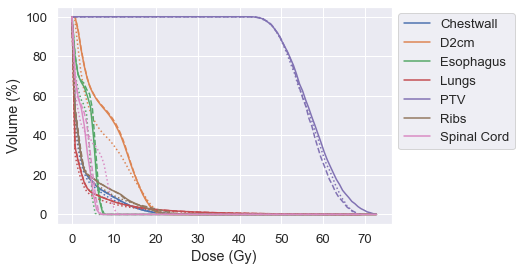

In [11]:
# Plot dose-volume histograms
for ii, folder in enumerate(folders):
    plt.figure()
    plotDvh(folder)
    plt.savefig(f'fig8{chr(97 + ii)}', bbox_inches='tight', dpi=300)

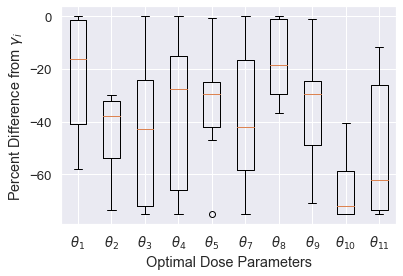

In [12]:
# Plot parameter distributions
labels = True

# Organize data
pars = []
for folder in folders:
    random = np.load(folder + '/bayes/res_linquad_dummy_minimize.pkl', allow_pickle=True)
    bayes = np.load(folder + '/bayes/res_linquad_gp_minimize.pkl', allow_pickle=True)
    p = bayes.opt_result.x
    d = random.opt_result.x
    for ii in range(len(folders)):
        gamma = bayes.goal_df.iloc[ii]['AcceptanceLevel']
        p[ii] = 100*(p[ii] - gamma)/gamma
        d[ii] = 100*(d[ii] - gamma)/gamma
    level = bayes.goal_df.iloc[6]['AcceptanceLevel']  # Lower limit of PTV Max is PTV D95, not zero
    level2 = bayes.goal_df.iloc[5]['AcceptanceLevel']
    p[5] = 100*(p[5] - level)/(level - level2)
    d[5] = 100*(d[5]- level)/(level - level2)
    for ii in range(7,11):
        level = bayes.goal_df.iloc[ii]['AcceptanceLevel']
        p[ii-1] = 100*(p[ii-1] - level)/level
        d[ii-1] = 100*(d[ii-1] - level)/level
    pars.append(p)
    pars.append(d)
    
# Plot results
plt.figure()
plt.boxplot(np.array(pars))
if labels:
    plt.xlabel('Optimal Dose Parameters')
    plt.ylabel('Percent Difference from $\gamma_i$')
    plt.xticks(np.arange(1, 11), [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$', r'$\theta_4$', r'$\theta_5$', r'$\theta_7$', r'$\theta_8$', r'$\theta_9$', r'$\theta_{10}$', r'$\theta_{11}$'])
else:
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.xticks(ticks=np.arange(0, 11), labels=[])
    plt.yticks(ticks=plt.yticks()[0], labels=[])
    plt.xlim(xlim)
    plt.ylim(ylim)
plt.savefig('fig9.png', dpi=300, bbox_inches='tight')